# Comparison of Multivariate vs. Bivariate Approach to Connectivity Estimation
**SYNCCIN 2025 Summer School**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/3_channels_correlations.ipynb)

---

This notebook demonstrates connectivity analysis using cross-correlation and delay estimation between multiple EEG channels. The analysis includes:
- Loading simulated 3-channel EEG data
- Cross-correlation analysis between channel pairs
- Delay estimation and visualization
- Network graph representation of channel connectivity
---


The simulation follows the scheme:

<img src="https://raw.githubusercontent.com/jzygierewicz/SYNCCIN_2025_summer_school/main/3chan_sim.png" alt="Simulated 3-channel EEG scheme" width="50%">

where channel 0  contains the orignal EEG alpha activity.

## Setup and Installation

First, let's install the required packages for Google Colab:

In [4]:
# Install required packages for Google Colab
!pip install plotly networkx scipy joblib ipywidgets xmltodict neurokit2


# Enable plotly for Colab
import plotly.io as pio
pio.renderers.default = "colab"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.7 MB/s eta 0:00:00


## Import Required Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import joblib
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Note: Custom modules (mtmvar and utils) will be imported after downloading
# Run the download section first to get these modules from the GitHub repository

## Load and Explore Data

The data files are now downloaded automatically from the GitHub repository. Let's load and explore the simulated 3-channel EEG data:

## Download Required Files

Let's download all the required files directly from the GitHub repository:
- Data files (`.joblib` format)
- Python modules (`mtmvar.py` and `utils.py`)

In [6]:
import urllib.request
import os

# GitHub repository information
github_user = "jzygierewicz"
repo_name = "SYNCCIN_2025_summer_school"
branch = "main"

# Files to download
files_to_download = [
    "simulated_3_channels.joblib",
    "mtmvar.py",
    "utils.py"
]

print("Downloading required files from GitHub repository...")

for filename in files_to_download:
    url = f"https://raw.githubusercontent.com/{github_user}/{repo_name}/{branch}/{filename}"

    try:
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)

        # Check if file was downloaded successfully
        if os.path.exists(filename):
            file_size = os.path.getsize(filename)
            print(f" {filename} downloaded successfully ({file_size:,} bytes)")
        else:
            print(f" Failed to download {filename}")

    except Exception as e:
        print(f" Error downloading {filename}: {str(e)}")
        print(f"  You may need to upload this file manually to your Colab session")

print("\nDownload process completed!")
print("\nAvailable files in current directory:")
for f in os.listdir("."):
    if f.endswith((".joblib", ".pkl", ".py")):
        size = os.path.getsize(f)
        print(f"  - {f} ({size:,} bytes)")

# Verify Python modules can be imported
print("\nTesting Python module imports...")
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot
    print(" mtmvar module imported successfully")
except ImportError as e:
    print(f" Error importing mtmvar: {e}")

try:
    from utils import describe_dict
    print(" utils module imported successfully")
except ImportError as e:
    print(f" Error importing utils: {e}")

print("\nSetup completed! You can now run the analysis.")

 simulated_3_channels.joblib downloaded successfully (48,392 bytes)
 mtmvar.py downloaded successfully (20,086 bytes)
 utils.py downloaded successfully (32,758 bytes)

Download process completed!

Available files in current directory:
  - utils.py (32,758 bytes)
  - mtmvar.py (20,086 bytes)
  - simulated_3_channels.joblib (48,392 bytes)

Testing Python module imports...
 mtmvar module imported successfully
 utils module imported successfully

Setup completed! You can now run the analysis.


## Import Custom Modules

Now that we've downloaded the custom modules, let's import the required functions:

In [7]:
# Import custom modules that were downloaded from the repository
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot
    print(" Successfully imported mtmvar functions")
except ImportError as e:
    print(f" Error importing mtmvar module: {e}")
    print("Make sure you ran the download section first!")

try:
    from utils import describe_dict
    print(" Successfully imported utils functions")
except ImportError as e:
    print(f" Error importing utils module: {e}")
    print("Make sure you ran the download section first!")

print("\nAll modules ready for EEG connectivity analysis!")

 Successfully imported mtmvar functions
 Successfully imported utils functions

All modules ready for EEG connectivity analysis!


In [8]:
# Load simulation data from simulated_3_channels.joblib
# This file was downloaded automatically from the GitHub repository
data = joblib.load('simulated_3_channels.joblib')
describe_dict(data)

sim1 = data['EEG']
Fs = data['Fs'].item()
N_chan, N_samp = sim1.shape

print(f"Number of channels: {N_chan}")
print(f"Number of samples: {N_samp}")
print(f"Sampling frequency: {Fs} Hz")

EEG: ndarray, shape=(3, 2000), dtype=float64
Fs: ndarray, shape=(1, 1), dtype=uint8
channels: dict, keys=['O1', 'O1_1dt', 'O1_2dt']
Number of channels: 3
Number of samples: 2000
Sampling frequency: 128 Hz


## Visualize the Signals

Let's plot the first 50 samples of each channel using interactive Plotly plots:

In [9]:
# Plot the signals using Plotly for interactive zooming
idx = np.arange(0, 50, 1)
time_samples = idx

fig = make_subplots(
    rows=N_chan, cols=1,
    shared_xaxes=True,
    subplot_titles=[f'Channel {i}' for i in range(N_chan)],
    vertical_spacing=0.05
)

colors = px.colors.qualitative.Set1[:N_chan]

for i in range(N_chan):
    fig.add_trace(
        go.Scatter(
            x=time_samples,
            y=sim1[i, idx],
            mode='lines+markers',
            name=f'Channel {i}',
            line=dict(color=colors[i]),
            marker=dict(size=4)
        ),
        row=i+1, col=1
    )

fig.update_layout(
    height=150*N_chan + 100,
    title_text="EEG Signals (First 150 samples)",
    showlegend=False
)

fig.update_xaxes(title_text="Time [samples]", row=N_chan, col=1)
fig.update_yaxes(title_text="Amplitude")

fig.show()

## Cross-Correlation Analysis

Now let's estimate cross-correlation functions for each pair of channels and find the delay for maximum correlation:

In [10]:
# Estimate cross correlation functions for each pair of channels
C = np.zeros((N_chan, N_chan, 2*N_samp-1))
corr = np.zeros((N_chan, N_chan))
delays = np.zeros((N_chan, N_chan))

print("Computing cross-correlations...")
for i in range(N_chan):
    for j in range(N_chan):
        if i != j: # this will cause the autocorrelations to remain zero, as they are not interesting
            # Calculate cross-correlation
            C[i, j, :] = signal.correlate(sim1[i, :], sim1[j, :], mode='full')
            lags = signal.correlation_lags(len(sim1[i, :]), len(sim1[j, :]), mode='full')
            max_lag = lags[np.argmax(C[i, j, :])]

            corr[i, j] = C[i, j, N_samp + max_lag]
            delays[i, j] = max_lag

            print(f"Max correlation between channel {i} and {j} is at lag {max_lag} samples")
            print(f"Max correlation value: {C[i, j, N_samp+max_lag]:.4f}")

# Normalize correlation matrix
corr = corr / np.max(corr)
print("\nCross-correlation analysis completed!")

Computing cross-correlations...
Max correlation between channel 0 and 1 is at lag -1 samples
Max correlation value: 1627.5862
Max correlation between channel 0 and 2 is at lag -2 samples
Max correlation value: 1600.4552
Max correlation between channel 1 and 0 is at lag 1 samples
Max correlation value: 1618.6802
Max correlation between channel 1 and 2 is at lag -1 samples
Max correlation value: 1593.1438
Max correlation between channel 2 and 0 is at lag 2 samples
Max correlation value: 1622.2773
Max correlation between channel 2 and 1 is at lag 1 samples
Max correlation value: 1626.9641

Cross-correlation analysis completed!


## Visualize Cross-Correlation Matrix

Heatmap showing the correlation strengths between channels, for this simulatios all channels are highly correlated. Note that the autocorrelation (on diagonal) were put to zero in the previous cell:

In [11]:
# Create interactive correlation matrix heatmap
channel_labels = [f'Ch {i}' for i in range(N_chan)]

fig = go.Figure(data=go.Heatmap(
    z=corr,
    x=channel_labels,
    y=channel_labels,
    colorscale='RdBu_r',
    zmid=0,
    zmin=-1,
    zmax=1,
    text=np.round(corr, 3),
    texttemplate="%{text}",
    textfont={"size": 12},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title='Cross-Correlation Matrix',
    xaxis_title='Channels',
    yaxis_title='Channels',
    width=500,
    height=500
)
fig.update_yaxes(autorange="reversed")
fig.show()

## Visualize Delays Matrix

Heatmap showing the time delays between channels:

In [12]:
# Create interactive delays matrix heatmap
fig = go.Figure(data=go.Heatmap(
    z=delays,
    x=channel_labels,
    y=channel_labels,
    colorscale='RdBu_r',
    text=delays.astype(int),
    texttemplate="%{text}",
    textfont={"size": 12},
    colorbar=dict(title="Delay (samples)")
))

fig.update_layout(
    title='Delays Matrix',
    xaxis_title='Channels',
    yaxis_title='Channels',
    width=500,
    height=500
)
fig.update_yaxes(autorange="reversed")
fig.show()

## Network Graph Visualization

Create a directed graph showing the connectivity between channels:

In [13]:
# Prepare data for network graph
delays_processed = delays.copy()
delays_processed[delays_processed > 0] = 0  # Put positive delays to 0

# Create a directed graph from the delays matrix
G = nx.from_numpy_array(delays_processed, create_using=nx.DiGraph)

# Set the weights of the edges to the corr values
for u, v, d in G.edges(data=True):
    d['weight'] = abs(corr[u, v])
    d['delay'] = abs(delays_processed[u, v])

# Compute the positions of the nodes using a layout algorithm
pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducible layout


## Network Plot

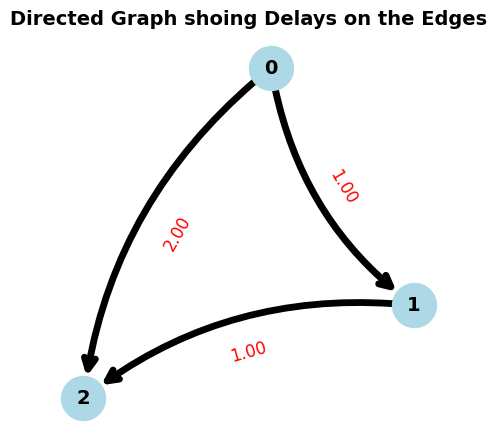

In [14]:
# Traditional matplotlib network plot
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, arrows=True,
        width=[d['weight'] * 5 for u, v, d in G.edges(data=True)],
        node_size=1000,
        edge_color='black',
        arrowstyle='->',
        arrowsize=20,
        connectionstyle='arc3,rad=0.2',
        node_color='lightblue',
        font_size=14,
        font_weight='bold')

edge_labels = {(u, v): f"{d['delay']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)

plt.title('Directed Graph showing Delays on the Edges', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Conclusions

**Key Findings:**

1. **Cross-correlation Matrix**: Shows the strength of coupling between channels at their optimal time delays
2. **Delays Matrix**: Reveals the time lags at which maximum correlation occurs between channel pairs
3. **Network Visualization**: Provides an intuitive representation of the connectivity structure

**Limitations of This Approach:**

- **Direct vs. Indirect Coupling**: This correlation-based method cannot distinguish between direct and indirect connections
- **Multivariate Effects**: The analysis doesn't account for the influence of other channels when examining pairwise relationships
- **Linear Assumptions**: Cross-correlation primarily captures linear relationships

## Next Steps:

For a more comprehensive connectivity analysis, consider:
- Partial correlation analysis to control for indirect effects
- Multivariate autoregressive (MVAR) modeling such as Directed transfer function (DTF) or partial directed coherence (PDC)

This bivariate approach serves as a useful starting point for understanding the basic connectivity patterns in your data.

---

**Educational Materials**: [SYNCCIN 2025 Repository](https://github.com/jzygierewicz/SYNCCIN_2025_summer_school)
- **Author**: Jarosław Żygierewicz
- **Institution**: University of Warsaw
- **Event**: SYNCCIN 2025 Summer School